In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from model import PINN
from SLoader import SLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x[0]).unsqueeze(1)
/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y[0]).unsqueeze(1)
/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_std = torch.tensor(x_std[0]).unsqueeze(1)
/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:53: UserWarning: To copy constr

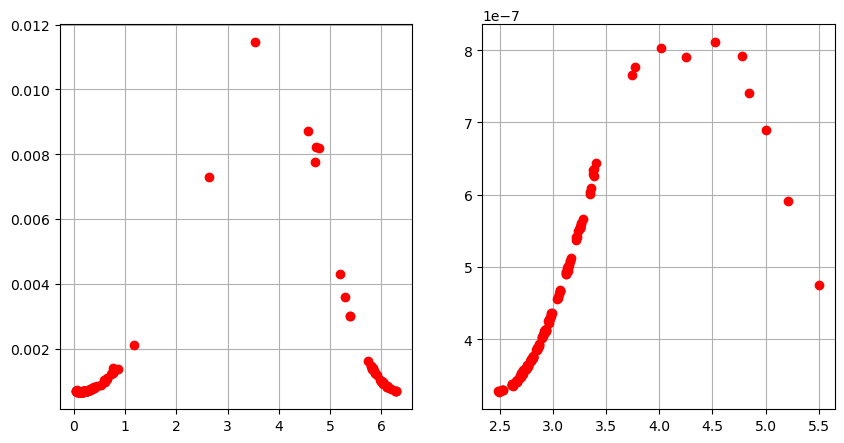

In [30]:
S1 = SLoader(files=["data/S1_astrometry_data.csv"], std_data=True, augment_data=True)
S2 = SLoader(files=["data/astrometry_NACO.csv", "data/astrometry_SHARP.csv"], std_data=True, augment_data=True)
#d = SLoader(files=["data/astrometry_NACO.csv"])
x = S2.phi
y = S2.u

fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(10,5))
ax.plot(x,y, 'ro')
ax.grid()

ax1.plot(S1.phi, S1.u, 'ro')
ax1.grid()



In [31]:
class SNN(nn.Module):
    def __init__(self, init_params=[0.88, 1.8e-2, 3.14]):
        super().__init__()
        self.e_ = torch.nn.Parameter(torch.tensor(init_params[0]))
        self.mu_ = torch.nn.Parameter(torch.tensor(init_params[1]))
        self.phi0_ = torch.nn.Parameter(torch.tensor(init_params[2]))
 
        # Enable gradient for trainable parameters
        self.e_requires_grad = True
        self.mu_.requires_grad = True
        self.phi0_.requires_grad = True

    def get_mu(self):
        return torch.abs(self.mu_)

    def get_e(self):
        return torch.abs(self.e_)
    
    def get_phi0(self):
        return self.phi0_
 
    def forward(self, x, M):
        mu = self.get_mu()
        e  = self.get_e()
        phi0 = self.get_phi0()

        u = mu/M * (1 + e*torch.cos(x + phi0))
        return u


class SSNN(nn.Module):
    def __init__(self, init_M=0.4):
        super().__init__()
        self.M_ = torch.nn.Parameter(torch.tensor(init_M))
        self.M_.requires_grad = True

        self.S1 = SNN(init_params=[0.5, 2.4e-10, 1.14])
        self.S2 = SNN(init_params=[0.88, 1.8e-2, 3.14])
    
    def get_M(self):
        return torch.abs(self.M_) 
    
    def forward(self, x1, x2):
        u1 = self.S1(x1, M=self.get_M())
        u2 = self.S2(x2, M=self.get_M())
        return u1, u2


In [32]:
# Initialize model
lr = 1e-8

model = SSNN()
#optimizer = optim.Adam(lr=lr, params=model.parameters())
optimizer = optim.Adam([{'params': model.M_, 'lr': 1e-4},
                        {'params': model.S2.mu_, 'lr': 1e-4},
                        {'params': model.S2.e_, 'lr': 1e-4},
                        {'params': model.S2.phi0_, 'lr': 1e-4},
                        {'params': model.S1.mu_, 'lr': 1e-8},
                        {'params': model.S1.e_, 'lr': 1e-4},
                        {'params': model.S1.phi0_, 'lr': 1e-4}
                        ])
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

losses = []
params1 = [[], [], []]
params2 = [[], [], []]

masses = []

weight = 1.

In [37]:
epochs = 10_000

for epoch in tqdm(range(epochs)):
    phi1, u1 = S1()
    phi2, u2 = S2()
    
    out1, out2 = model(phi1, phi2)
    #loss = criterion(out, u)
    #loss = criterion(out1, u1) + criterion(out2, u2)
    loss = criterion(out1 - torch.mean(out1), u1 - torch.mean(u1)) + criterion(out2 - torch.mean(out2), u2 - torch.mean(u2))
    #loss = criterion(1./out1, 1./u1) + criterion(1./out2, 1./u2)
    #loss *= weight
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.cpu().detach().numpy())

    params1[0].append(model.S1.get_e().item())
    params1[1].append(model.S1.get_mu().item())
    params1[2].append(model.S1.get_phi0().item())

    params2[0].append(model.S2.get_e().item())
    params2[1].append(model.S2.get_mu().item())
    params2[2].append(model.S2.get_phi0().item())

    masses.append(model.get_M().item())

    weight += 0.001


100%|██████████| 10000/10000 [00:23<00:00, 420.37it/s]


In [38]:

print("\n===== S2 =====")
print("e =", model.S1.get_e().item())
print("p =", model.get_M().item()/model.S1.get_mu().item())
#print("p =", model.S2.get_p().item())
print("mu =", model.S1.get_mu().item())
print("phi0 = ", model.S1.get_phi0().item())

print("\n===== S2 =====")
print("e =", model.S2.get_e().item())
print("p =", model.get_M().item()/model.S2.get_mu().item())
#print("p =", model.S2.get_p().item())
print("mu =", model.S2.get_mu().item())
print("phi0 = ", model.S2.get_phi0().item())
print("\nM =", model.get_M().item())


===== S2 =====
e = 0.5
p = 1910907.0328559862
mu = 2.2510650410367816e-07
phi0 =  1.1399999856948853

===== S2 =====
e = 0.8498576283454895
p = 165.63560885344197
mu = 0.002597011625766754
phi0 =  2.9121735095977783

M = 0.4301576018333435


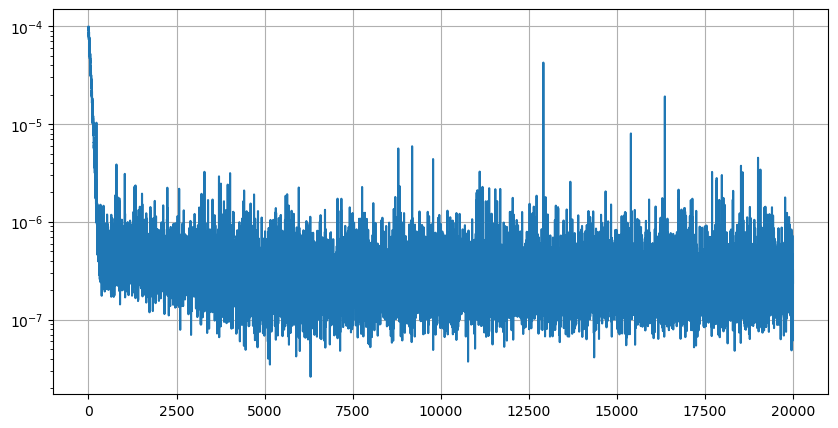

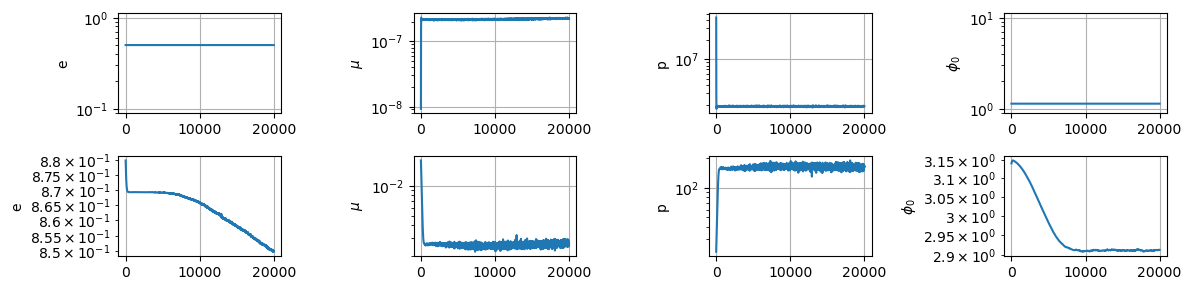

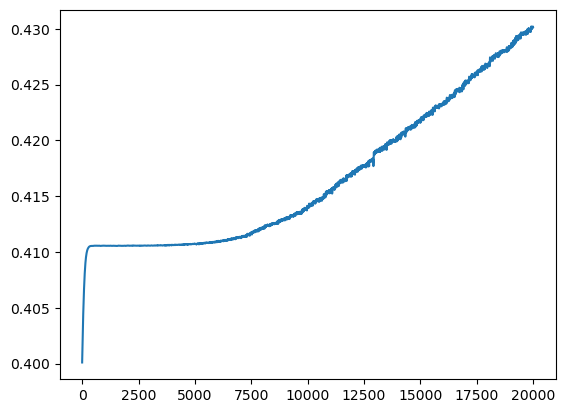

In [39]:

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(losses)
ax.grid(); ax.set_yscale("log")
plt.show()


fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(12,3))
[[axij.set_yscale("log") for axij in axi] for axi in ax]

ax[0,0].plot(params1[0])
ax[0,0].set_ylabel("e")
ax[0,0].grid()

ax[0,1].plot(params1[1])
ax[0,1].set_ylabel(r"$\mu$")
ax[0,1].grid()

ax[0,2].plot(np.array(masses)/np.array(params1[1]))
ax[0,2].set_ylabel("p")
ax[0,2].grid()

ax[0,3].plot(params1[2])
ax[0,3].set_ylabel(r"$\phi_0$")
ax[0,3].grid()


ax[1,0].plot(params2[0])
ax[1,0].set_ylabel("e")
ax[1,0].grid()

ax[1,1].plot(params2[1])
ax[1,1].set_ylabel(r"$\mu$")
ax[1,1].grid()

ax[1,2].plot(np.array(masses)/np.array(params2[1]))
ax[1,2].set_ylabel("p")
ax[1,2].grid()

ax[1,3].plot(params2[2])
ax[1,3].set_ylabel(r"$\phi_0$")
ax[1,3].grid()

plt.tight_layout()
plt.show()

plt.plot(masses)

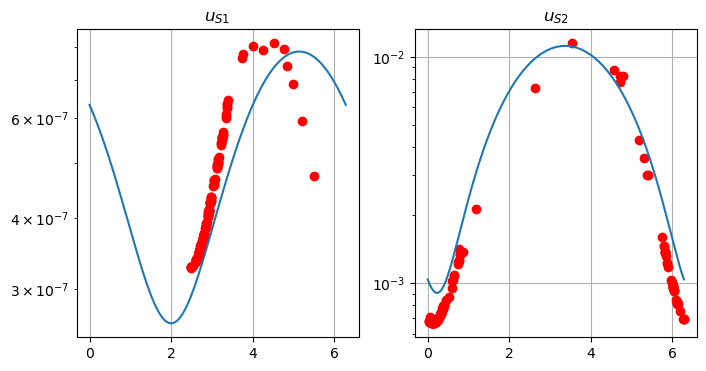

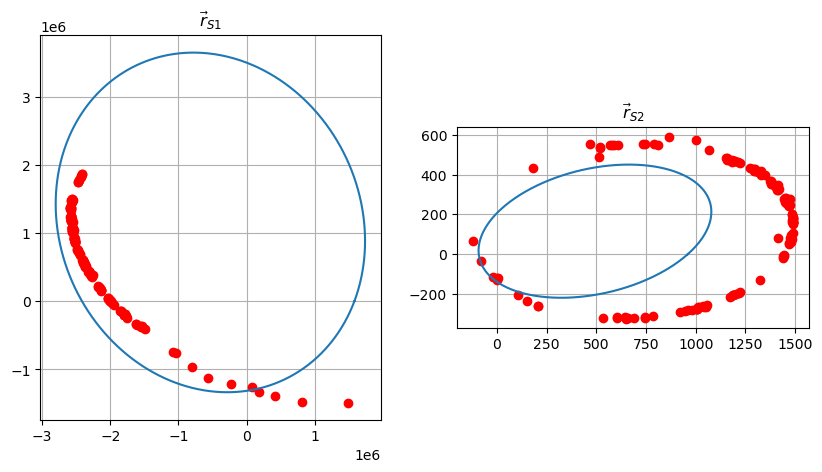

In [40]:
u1 = S1.u
phi1 = S1.phi
u2 = S2.u
phi2 = S2.phi

tphi = torch.linspace(0, 2*torch.pi, steps=1000).view(-1,1)

out1 = model.S1(tphi, M=model.get_M()).detach().numpy()
out2 = model.S2(tphi, M=model.get_M()).detach().numpy()

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(8,4))
ax.grid()
ax.set_title(r"$u_{S1}$")
ax.plot(phi1, u1, 'ro')
ax.plot(tphi, out1)
ax.set_yscale("log")

ax2.grid()
ax2.set_title(r"$u_{S2}$")
ax2.plot(phi2, u2, 'ro')
ax2.plot(tphi, out2)
ax2.set_yscale("log")



fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax.grid()
ax.plot(torch.cos(phi1)/u1, torch.sin(phi1)/u1, 'ro')
ax.plot(torch.cos(tphi)/out1, torch.sin(tphi)/out1)
ax.set_title(r"$\vec{r}_{S1}$")
ax.set_aspect('equal')

ax2.grid()
ax2.plot(torch.cos(phi2)/u2, torch.sin(phi2)/u2, 'ro')
ax2.plot(torch.cos(tphi)/out2, torch.sin(tphi)/out2)
ax2.set_title(r"$\vec{r}_{S2}$")
ax2.set_aspect('equal')